# About

## General

The model we will develop aims to predict the unemployment rate in future months based on historical unemployment rate data. By leveraging the power of advanced machine learning techniques, the model will be capable of capturing patterns and trends in the data, allowing it to make informed predictions about the state of the economy. The model's predictions can provide valuable insights for policymakers, businesses, and individuals, enabling them to make more informed decisions in response to changes in the job market.

## TDA

By using the Temporal Decaying Accumulator (TDA) activation function in our model, we aim to emphasize the importance of recent unemployment rate data while diminishing the influence of older data. This approach is particularly well-suited for time-series data, as it allows the model to adapt to changes in the underlying patterns of the data over time. In doing so, the model becomes more robust and better equipped to make accurate predictions in the face of evolving economic conditions.

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tda import tda

%matplotlib inline

## Dataset

Data obtained from [FRED Economic Data](https://fred.stlouisfed.org/series/UNRATE).
Downloaded file `UNRATE.csv` must be placed in the `root` of this repository.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_and_preprocess_data(csv_path, sequence_length=5):
    # Load the data
    data = pd.read_csv(csv_path)
    data['DATE'] = pd.to_datetime(data['DATE'])
    
    # Prepare input (X) and output (y) arrays
    X = data['DATE'].values.reshape(-1, 1)
    y = data['UNRATE'].values
    
    # Scale the input data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    # Reshape X to have the shape (num_samples, sequence_length, num_features)
    X = np.array([X[i: i + sequence_length] for i in range(len(X) - sequence_length)])
    
    # Remove the first (sequence_length - 1) samples from y
    y = y[sequence_length:, np.newaxis]
    
    return X, y

sequence_length = 12
X, y = load_and_preprocess_data('UNRATE.csv', sequence_length=sequence_length)
print(X.shape, y.shape)

(890, 12, 1) (890, 1)


In [3]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
# Create DataLoader instances for train and test sets
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

In [4]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            # print(f'Outputs {outputs} -> y {batch_y}')
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Apply gradient clipping
            optimizer.step()
            losses.append(loss.item())

        train_losses.append(np.mean(losses))

        # Evaluate the model on the test set
        model.eval()
        tlosses = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                tlosses.append(loss.item())

        test_losses.append(np.mean(tlosses))

        print(f"\r{model.ac}: Epoch [{epoch+1}/{num_epochs}], Test Loss: {np.mean(test_losses):.4f}", end="")
    
    print()
    return train_losses, test_losses

In [5]:
class TDANetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_window, max_value, scaling_factor, op='mean'):
        super(TDANetwork, self).__init__()
        self.layer1 = nn.Linear(input_size * time_window, hidden_size)
        self.ac = tda.TDAActivation(time_window, max_value, scaling_factor, op=op)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the input tensor along the time_window dimension
        x = self.layer1(x)
        x = x.unsqueeze(-1)  # Add an extra dimension for the time_window
        x = self.ac(x)
        x = self.layer2(x)
        return x

In [6]:
input_size = X.shape[-1]
hidden_size = 128
output_size = 1
time_window = sequence_length
max_value = 12.0
scaling_factor = 0.19
learning_rate = 0.4

model = TDANetwork(input_size, hidden_size, output_size, time_window, max_value, scaling_factor, op='sum')
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use a smaller learning rate

num_epochs = 1000
tda_loss, tda_test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)

TDAActivation(): Epoch [1000/1000], Test Loss: 0.6079


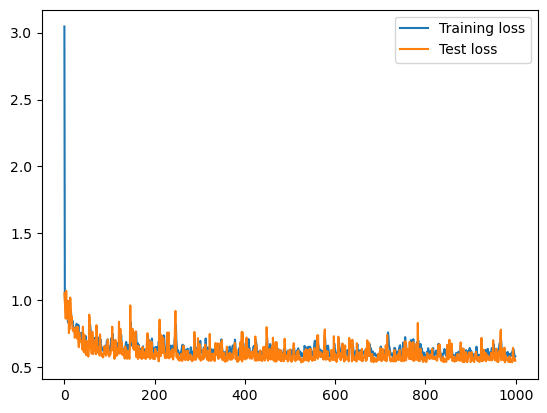

In [7]:
plt.plot(tda_loss, label='Training loss')
plt.plot(tda_test_loss, label='Test loss')
plt.legend()
plt.show()